In [ ]:
!unzip /content/drive/MyDrive/AE/NewDataset.zip -d /content/trainAE/

In [ ]:
import os

# Path to the folder
folder_path = '/content/trainAE/NewDataset/CloudyDataset'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Get the number of files
num_files = len(files)

print(f"Number of files in the folder: {num_files}")

Number of files in the folder: 3018


## Load the dataset for inferencing or training by choosing the images_input to be the cloudy images for training, test_images_output is the cloudy images for testing. The images_output is the clear images for training and test_images_output is the clear images for testing.
Link to the new dataset:
https://drive.google.com/file/d/1FGu5vzlIVuBocqXdRuVuX2nZaMUWvsPe/view?usp=sharing
Link to the weights for the AE that does cloud removal:
https://drive.google.com/file/d/1qxeM8uh9yec8QEuimafB78fyGSD-RBgP/view?usp=sharing

In [ ]:
import os
import cv2
import random
from google.colab.patches import cv2_imshow

# Path to the folder containing images
folder_path = '/content/trainAE/NewDataset/ClearDataset'

# Get the list of files in the folder
files = os.listdir(folder_path)

# Display 10 random images
for _ in range(10):
    # Select a random image from the list
    random_image_name = random.choice(files)
    # Construct the full path to the random image
    random_image_path = os.path.join(folder_path, random_image_name)
    # Read and display the random image
    random_image = cv2.imread(random_image_path)
    cv2_imshow(random_image)
    cv2.waitKey(0)

# Close all OpenCV windows
cv2.destroyAllWindows()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras import layers
from keras.datasets import mnist
from keras.models import Model
import os
import cv2
import numpy as np
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
input_folder = '/content/trainAE/NewDataset/CloudyDataset'
train_folder = 'Cloudytrain'
test_folder = 'Cloudytest'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

files = os.listdir(input_folder)

num_train = int(len(files) * 0.95)
num_test = int(len(files) * 0.05)

train_files = files[:num_train]
test_files = files[-num_test:]

for file_name in train_files:
    src_path = os.path.join(input_folder, file_name)
    dst_path = os.path.join(train_folder, file_name)
    shutil.copy(src_path, dst_path)

for file_name in test_files:
    src_path = os.path.join(input_folder, file_name)
    dst_path = os.path.join(test_folder, file_name)
    shutil.copy(src_path, dst_path)

print("Dataset split into train and test folders.")

Dataset split into train and test folders.


In [ ]:
input_folder = '/content/trainAE/NewDataset/ClearDataset'
train_folder = 'Cleartrain'
test_folder = 'Cleartest'

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)


for file_name in tqdm(os.listdir("/content/Cloudytrain/")):
    src_path = os.path.join(input_folder, file_name)
    dst_path = os.path.join(train_folder, file_name)
    shutil.copy(src_path, dst_path)

for file_name in tqdm(os.listdir("/content/Cloudytest/")):
    src_path = os.path.join(input_folder, file_name)
    dst_path = os.path.join(test_folder, file_name)
    shutil.copy(src_path, dst_path)

print("Dataset split into train and test folders.")

100%|██████████| 150/150 [00:00<00:00, 8837.06it/s]

Dataset split into train and test folders.


In [ ]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 256, 256, 3))
    return array

def display(array1, array2):
    """Displays three random images from each array horizontally stacked, each pair printed one below the other."""
    n = 3  # Display three images
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices]
    images2 = array2[indices]

    # Convert BGR to RGB
    images1_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.shape[2] == 3 else img for img in images1]
    images2_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.shape[2] == 3 else img for img in images2]

    # Increase figure size
    plt.figure(figsize=(6, 15))

    for i in range(n):
        stacked_images = np.hstack((images1_rgb[i], images2_rgb[i]))
        plt.imshow(stacked_images)
        plt.axis('off')
        plt.title('Image {}'.format(i + 1))
        plt.show()

In [ ]:
def load_data(data_folder):
    images = []
    names = []
    for file in tqdm(os.listdir(data_folder), unit="image"):
        image_path = os.path.join(data_folder, file)

        image = cv2.imread(image_path)
        images.append(image)
        names.append(file)
        if image is None:
            print("No images found", image_path)
            continue
    # Convert lists to numpy arrays
    images = np.array(images)
    names = np.array(names)
    return images, names

data_folder = '/content/Cloudytrain/'

# Load the data
images_input, images_input_names = load_data(data_folder)

print("Images shape:", images_input.shape)

100%|██████████| 3417/3417 [01:30<00:00, 37.55image/s] 


Images shape: (3417, 256, 256, 3)


In [ ]:
data_folder = '/content/Cleartrain/'
images_output, images_output_names = load_data(data_folder)
print("Images shape:", images_output.shape)

100%|██████████| 3417/3417 [47:06<00:00,  1.21image/s]


Images shape: (3417, 256, 256, 3)


In [ ]:

data_folder = '/content/Cloudytest/'
# Load the data
test_images_input, test_images_names = load_data(data_folder)

print("Images shape:", test_images_input.shape)

100%|██████████| 301/301 [01:19<00:00,  3.80image/s] 

Images shape: (301, 256, 256, 3)


In [ ]:
data_folder = '/content/Cleartest/'

test_images_output,test_images_names_output = load_data(data_folder)

100%|██████████| 301/301 [00:01<00:00, 179.41image/s]


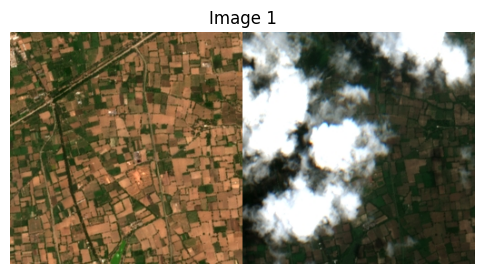

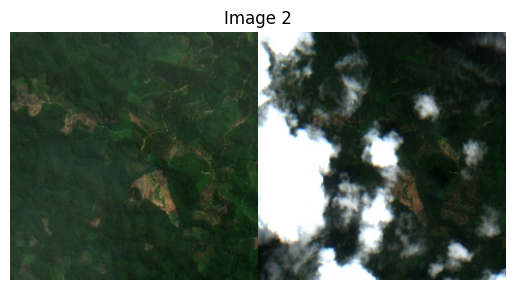

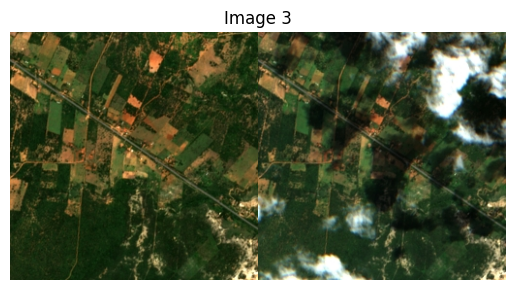

In [ ]:
# Normalize and reshape the data
train_data = preprocess(images_output)
test_data = preprocess(test_images_output)

# Create a copy of the data with added noise
noisy_train_data = preprocess(images_input)
noisy_test_data = preprocess(test_images_input)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:

input = layers.Input(shape=(256, 256, 3))

# Encoder
x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)
# Decoder
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss=SSIMLoss)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 128, 128, 128)     147584

In [ ]:
history = autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=50,
    batch_size=8,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/50
428/428 [==============================] - 60s 141ms/step - loss: 0.3827 - val_loss: 0.6366
Epoch 2/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3831 - val_loss: 0.6213
Epoch 3/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3814 - val_loss: 0.6362
Epoch 4/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3821 - val_loss: 0.6414
Epoch 5/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3821 - val_loss: 0.6368
Epoch 6/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3814 - val_loss: 0.6330
Epoch 7/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3821 - val_loss: 0.6249
Epoch 8/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3813 - val_loss: 0.6211
Epoch 9/50
428/428 [==============================] - 60s 140ms/step - loss: 0.3808 - val_loss: 0.6274
Epoch 10/50
428/428 [==============================] - 60s 140ms/step - l

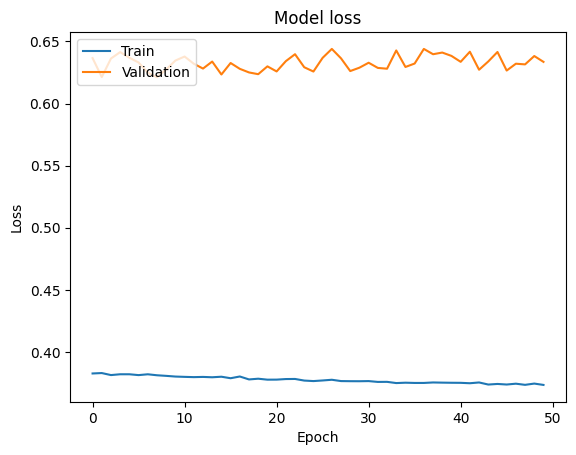

In [ ]:
# Plot training & validation accuracy values
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
autoencoder.load_weights('/content/drive/MyDrive/AE/AEBigSSIM.h5')

In [ ]:
import tensorflow as tf

In [ ]:
predictions = autoencoder.predict(noisy_test_data,batch_size=8)

38/38 [==============================] - 2s 47ms/step


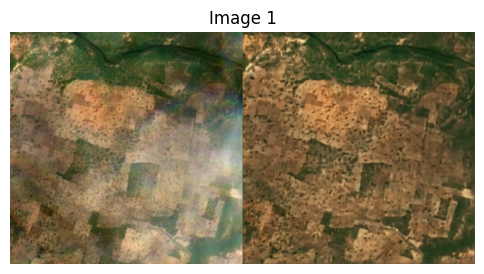

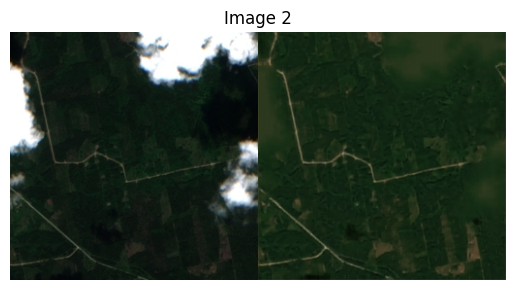

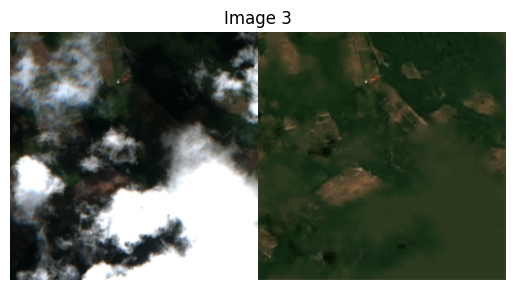

In [ ]:
display(noisy_test_data, predictions)

In [ ]:
def display(array1, array2, array3):
    """Saves the input images with names passed to it. Change directories for T1, T2, T0 for inferencing on different datasets"""
    indices = range(len(array1))
    images1 = array1[indices]
    images2 = array2[indices]
    names = array3[indices]

    # Convert BGR to RGB
    images1_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.shape[2] == 3 else img for img in images1]
    images2_rgb = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img.shape[2] == 3 else img for img in images2]

    # Increase figure size
    plt.figure(figsize=(6, 15))

    for i in range(len(array1)):

        plt.imsave(f"/content/drive/MyDrive/AE/DiffPreds/T1/{names[i]}", images2_rgb[i])


In [ ]:
display(noisy_test_data, predictions, test_images_names)

<Figure size 600x1500 with 0 Axes>